In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import anndata
import sklearn

In [7]:
ad = anndata.read_h5ad('../../organoid_anndata.h5ad')

dfX = ad.X



/Users/dennyal/miniforge3/envs/tcf7l2/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
na_series = ad.obs['edit_id'].isna()
wt_ko_series = ad.obs['edit_id'].isin(['WT/WT', '-/-', "WT/-"])
bool_series = ad.obs['Day'] == 30
combined_series = bool_series & ~na_series & wt_ko_series

In [10]:
dfX

array([[ 0.52087814,  0.4331087 ,  0.70902944, ...,  0.31265116,
        -1.4234422 , -0.1381145 ],
       [ 0.83655953,  0.9222484 ,  1.006546  , ..., -0.75249124,
         0.07718662, -0.10263793],
       [-0.4036175 , -0.23586184, -0.14456558, ...,  1.4100385 ,
        -1.5894717 , -0.15649392],
       ...,
       [ 0.20519666,  0.4618816 ,  0.25284106, ..., -1.3391926 ,
        -1.5487465 , -0.06887107],
       [ 1.2198869 ,  0.9222484 ,  0.93461406, ..., -0.21236707,
        -1.3056208 , -0.08596821],
       [ 0.52087814,  1.497707  ,  0.92996013, ...,  1.5164989 ,
        -0.42906693, -0.08938764]], shape=(34200, 171), dtype=float32)

In [11]:
scaler = sklearn.preprocessing.StandardScaler()
dfX = scaler.fit(dfX).transform(dfX)

In [12]:
dfX

array([[ 0.52087814,  0.4331087 ,  0.70902944, ...,  0.31265116,
        -1.4234422 , -0.1381145 ],
       [ 0.83655953,  0.9222484 ,  1.006546  , ..., -0.75249124,
         0.07718661, -0.10263793],
       [-0.4036175 , -0.23586184, -0.1445656 , ...,  1.4100385 ,
        -1.5894717 , -0.15649392],
       ...,
       [ 0.20519666,  0.4618816 ,  0.25284106, ..., -1.3391926 ,
        -1.5487465 , -0.06887107],
       [ 1.2198869 ,  0.9222484 ,  0.93461406, ..., -0.21236706,
        -1.3056208 , -0.08596821],
       [ 0.52087814,  1.497707  ,  0.92996013, ...,  1.5164989 ,
        -0.42906693, -0.08938764]], shape=(34200, 171), dtype=float32)

In [13]:
day30_tcf = anndata.AnnData(X = dfX[combined_series], obs = ad.obs[combined_series], var = ad.var)

In [14]:
day30_tcf.X

array([[-2.0496707 , -2.1061022 , -2.0138774 , ...,  0.87585473,
         0.70747006, -0.09152479],
       [-1.6663433 , -1.8974985 , -1.7412851 , ...,  1.0056535 ,
         0.7784269 , -0.08041165],
       [-2.1774464 , -1.9622375 , -2.0425224 , ...,  0.808885  ,
        -0.61352867, -0.07613736],
       ...,
       [-0.4938122 , -0.74658126, -0.48807624, ..., -0.3773634 ,
        -0.5328228 , -0.07271793],
       [-0.90720457, -0.9623782 , -0.8232403 , ...,  1.25402   ,
        -0.9390214 , -0.08083907],
       [-0.6817178 , -0.8688662 , -0.68437773, ...,  0.82236546,
        -0.9016256 , -0.07143564]], shape=(688, 171), dtype=float32)

/Users/dennyal/miniforge3/envs/tcf7l2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


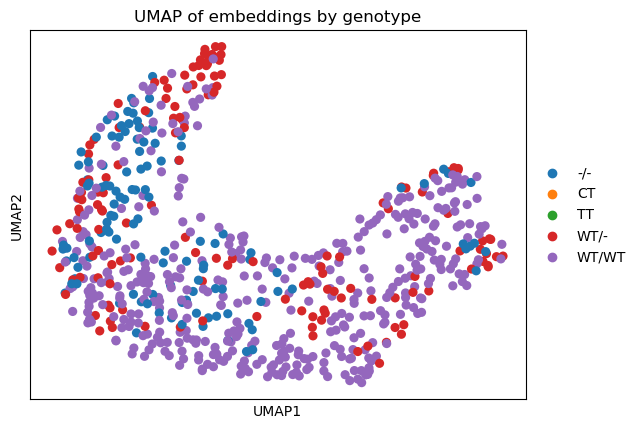

In [15]:
adata = day30_tcf.copy()
sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=70)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)

# plot
sc.pl.umap(adata, color='edit_id', title='UMAP of embeddings by genotype')

In [16]:
import pandas as pd
from scipy.stats import f_oneway

day30_tcf.obs.index = day30_tcf.obs['SampleBarcode']

df = pd.DataFrame(day30_tcf.X, columns=day30_tcf.var_names, index=day30_tcf.obs.index)

In [17]:
df['genotype'] = day30_tcf.obs['edit_id']

In [18]:
df.genotype.unique()

['WT/WT', 'WT/-', '-/-']
Categories (5, object): ['-/-', 'CT', 'TT', 'WT/-', 'WT/WT']

In [19]:
anova_results = []
for feat in day30_tcf.var_names:
    groups = [df.loc[df.genotype == g, feat].dropna() for g in df.genotype.unique()]
    stat, p = f_oneway(*groups)
    anova_results.append({'feature': feat, 'F': stat, 'p': p})

anova_df = pd.DataFrame(anova_results).sort_values('p')
anova_df.head(10)


,feature,F,p
165,FormFactor_halo,46.790821,8.960786e-20
164,Perimeter_um_halo,38.739708,1.150504e-16
160,Perimeter_halo,38.739708,1.150504e-16
137,Variance_Sum_Ave_Texture,35.040981,3.243716e-15
3,Area_shape,35.040974,3.243739e-15
8,Area_um^2_shape,35.040974,3.243739e-15
19,TextDissimilarity_dist_0angle0.0,34.985611,3.410826e-15
37,TextDissimilarity_dist_0angle3.14,34.985611,3.410826e-15
31,TextDissimilarity_dist_0angle2.09,34.968983,3.462677e-15
20,TextHomo_dist_0angle0.0,34.964642,3.476343e-15


In [20]:
df

Feature Name,MinDiameter_shape,MaxDiameter_shape,MeanDiameter_shape,Area_shape,Perimeter_shape,MinDiameter_um_shape,MaxDiameter_um_shape,MeanDiameter_um_shape,Area_um^2_shape,Perimeter_um_shape,...,MaxDiameter_um_halo,MeanDiameter_um_halo,Perimeter_um_halo,FormFactor_halo,Solidity_halo,Extent_halo,Eccentricity_halo,Orientation_halo,Compactness_halo,genotype
SampleBarcode,,,,,,,,,,,,,,,,,,,,,
AS0009-03-MCS-003,-2.049671,-2.106102,-2.013877,-1.774345,-1.760664,-2.049671,-2.106102,-2.013877,-1.774345,-1.760664,...,-0.258641,0.254836,0.295447,-0.471558,-0.161123,0.224924,0.875855,0.707470,-0.091525,WT/WT
AS0009-03-MCS-003,-1.666343,-1.897498,-1.741285,-1.623420,-1.529828,-1.666343,-1.897498,-1.741285,-1.623420,-1.529828,...,0.730319,0.368149,0.373337,-0.542810,-0.299450,-0.606246,1.005654,0.778427,-0.080412,WT/WT
AS0009-03-MCS-003,-2.177446,-1.962237,-2.042522,-1.788942,-1.766291,-2.177447,-1.962237,-2.042522,-1.788942,-1.766291,...,3.247672,0.235370,0.804524,-0.719856,-0.841424,-1.824227,0.808885,-0.613529,-0.076137,WT/WT
AS0009-03-MCS-003,-2.057187,-1.962237,-1.941823,-1.736565,-1.681425,-2.057187,-1.962237,-1.941823,-1.736565,-1.681424,...,1.035997,0.329836,0.472427,-0.593269,-0.483620,-0.820392,0.066809,0.200408,-0.077847,WT/WT
AS0033-02-MMR-001,-0.847075,-1.055890,-0.975733,-1.083289,-0.916012,-0.847075,-1.055890,-0.975733,-1.083289,-0.916012,...,-0.186716,0.182791,-0.610558,0.067875,-0.343054,-0.285307,-1.701390,0.783019,-0.068871,WT/WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AS0009-03-MCS-003,-1.606213,-0.897639,-1.636643,-1.559709,-1.104923,-1.606214,-0.897639,-1.636644,-1.559709,-1.104923,...,0.694357,0.127941,0.405321,-0.595124,-0.429386,-0.789200,1.451079,0.356056,-0.071008,WT/WT
AS0051-03-MCS-003,-0.749364,-1.048697,-0.827721,-0.959078,-0.869280,-0.749364,-1.048697,-0.827721,-0.959078,-0.869280,...,2.330635,0.101403,0.965953,-0.740007,-0.875676,-1.319902,1.545048,-0.984951,-0.088533,WT/WT
AS0051-03-MCS-003,-0.493812,-0.746581,-0.488076,-0.649817,-0.617225,-0.493812,-0.746581,-0.488076,-0.649817,-0.617225,...,0.065019,0.373976,0.027663,-0.395801,-0.419646,-0.335274,-0.377363,-0.532823,-0.072718,WT/WT


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [22]:
rf = RandomForestClassifier(n_estimators=500, random_state=0)

In [23]:
fit = rf.fit(day30_tcf.X, day30_tcf.obs['edit_id'])

In [24]:
importances = pd.Series(rf.feature_importances_, index=day30_tcf.var_names)
importances.sort_values(ascending=False).head(15)

Feature Name
Median_intensity                   0.020372
Min_intensity                      0.019993
LowerQuartile_intensity            0.018755
Mean_intensity                     0.014464
MAD_intensity                      0.014383
FormFactor_shape                   0.014219
Location_CenterMass_intensity_Y    0.014193
UpperQuartile_intensity            0.013990
MassDisplacement_intensity         0.013531
Solidity_shape                     0.013227
MeanDiameter_halo                  0.012819
Perimeter_um_halo                  0.012510
Std_intensity                      0.012437
Solidity_halo                      0.012236
MeanDiameter_um_halo               0.012169
dtype: float64

/var/folders/mr/zvvy4g790mz914r9cm23_92rl3zggr/T/ipykernel_44926/560978171.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="genotype", y=feat, palette="Set2")
/var/folders/mr/zvvy4g790mz914r9cm23_92rl3zggr/T/ipykernel_44926/560978171.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="genotype", y=feat, palette="Set2")
/var/folders/mr/zvvy4g790mz914r9cm23_92rl3zggr/T/ipykernel_44926/560978171.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="genotype", y=feat, palette="Set2")
/var/folders/mr/zvvy4g

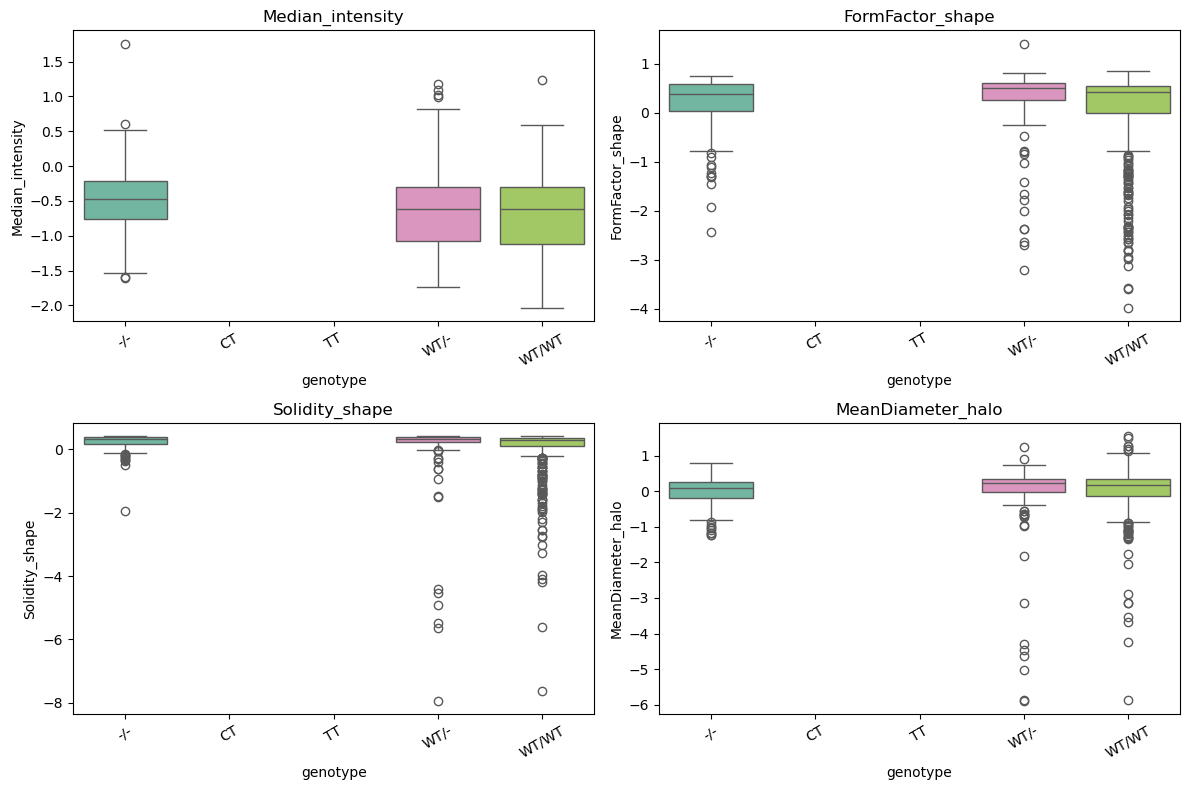

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
top_feats = [
    "Median_intensity", "FormFactor_shape", "Solidity_shape", "MeanDiameter_halo"
]

plt.figure(figsize=(12,8))
for i,feat in enumerate(top_feats,1):
    plt.subplot(2,2,i)
    sns.boxplot(data=df, x="genotype", y=feat, palette="Set2")
    plt.title(feat)
    plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


/var/folders/mr/zvvy4g790mz914r9cm23_92rl3zggr/T/ipykernel_63493/3997543978.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="genotype", y="geno_projection", palette="coolwarm")


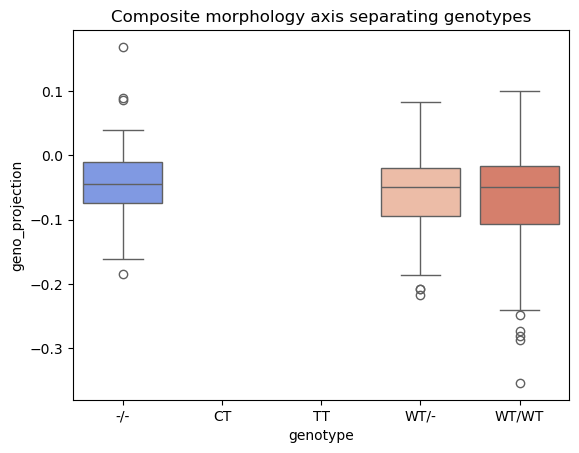

In [104]:
import numpy as np

importance = {
    "Median_intensity": 0.020372, 
"Min_intensity" :                     0.019993,
"LowerQuartile_intensity" :           0.018755,
"Mean_intensity"  :                   0.014464,
"MAD_intensity"  :                    0.014383,
"FormFactor_shape"  :                 0.014219,
"Location_CenterMass_intensity_Y" :   0.014193,
"UpperQuartile_intensity":            0.013990,
"MassDisplacement_intensity":         0.013531,
"Solidity_shape"   :                  0.013227,
"MeanDiameter_halo"   :               0.012819,
"Perimeter_um_halo"       :           0.012510,
"Std_intensity"      :                0.012437,
"Solidity_halo"   :                   0.012236,
"MeanDiameter_um_halo"    :           0.012169
}

df["geno_projection"] = np.sum([
    df[f] * w for f,w in importance.items()
], axis=0)

sns.boxplot(data=df, x="genotype", y="geno_projection", palette="coolwarm")
plt.title("Composite morphology axis separating genotypes")
plt.show()

<Axes: xlabel='genotype', ylabel='Area_shape'>

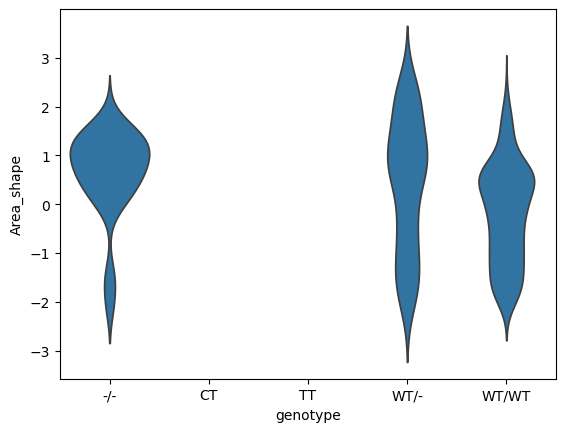

In [106]:
sns.violinplot(data=df, x="genotype", y="Area_shape", inner=None)

In [62]:
df

Feature Name,MinDiameter_shape,MaxDiameter_shape,MeanDiameter_shape,Area_shape,Perimeter_shape,MinDiameter_um_shape,MaxDiameter_um_shape,MeanDiameter_um_shape,Area_um^2_shape,Perimeter_um_shape,...,MeanDiameter_um_halo,Perimeter_um_halo,FormFactor_halo,Solidity_halo,Extent_halo,Eccentricity_halo,Orientation_halo,Compactness_halo,genotype,geno_projection
SampleBarcode,,,,,,,,,,,,,,,,,,,,,
AS0009-03-MCS-003,-2.049671,-2.106102,-2.013877,-1.774345,-1.760664,-2.049671,-2.106102,-2.013877,-1.774345,-1.760664,...,0.254836,0.295447,-0.471558,-0.161123,0.224924,0.875855,0.707470,-0.091525,WT/WT,-0.061343
AS0009-03-MCS-003,-1.666343,-1.897498,-1.741285,-1.623420,-1.529828,-1.666343,-1.897498,-1.741285,-1.623420,-1.529828,...,0.368149,0.373337,-0.542810,-0.299450,-0.606246,1.005654,0.778427,-0.080412,WT/WT,-0.051446
AS0009-03-MCS-003,-2.177446,-1.962237,-2.042522,-1.788942,-1.766291,-2.177447,-1.962237,-2.042522,-1.788942,-1.766291,...,0.235370,0.804524,-0.719856,-0.841424,-1.824227,0.808885,-0.613529,-0.076137,WT/WT,-0.025412
AS0009-03-MCS-003,-2.057187,-1.962237,-1.941823,-1.736565,-1.681425,-2.057187,-1.962237,-1.941823,-1.736565,-1.681424,...,0.329836,0.472427,-0.593269,-0.483620,-0.820392,0.066809,0.200408,-0.077847,WT/WT,-0.031270
AS0033-02-MMR-001,-0.847075,-1.055890,-0.975733,-1.083289,-0.916012,-0.847075,-1.055890,-0.975733,-1.083289,-0.916012,...,0.182791,-0.610558,0.067875,-0.343054,-0.285307,-1.701390,0.783019,-0.068871,WT/WT,-0.170827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AS0009-03-MCS-003,-1.606213,-0.897639,-1.636643,-1.559709,-1.104923,-1.606214,-0.897639,-1.636644,-1.559709,-1.104923,...,0.127941,0.405321,-0.595124,-0.429386,-0.789200,1.451079,0.356056,-0.071008,WT/WT,-0.156833
AS0051-03-MCS-003,-0.749364,-1.048697,-0.827721,-0.959078,-0.869280,-0.749364,-1.048697,-0.827721,-0.959078,-0.869280,...,0.101403,0.965953,-0.740007,-0.875676,-1.319902,1.545048,-0.984951,-0.088533,WT/WT,-0.119005
AS0051-03-MCS-003,-0.493812,-0.746581,-0.488076,-0.649817,-0.617225,-0.493812,-0.746581,-0.488076,-0.649817,-0.617225,...,0.373976,0.027663,-0.395801,-0.419646,-0.335274,-0.377363,-0.532823,-0.072718,WT/WT,-0.118966
